In [1]:
import os

from PIL import Image
import skimage.io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def psnr(original, decoded):
    mse = np.mean(np.power(original - decoded, 2))
    if(mse == 0):
        return 100
    max_val = 255.0
    psnr = 20 * np.log10(max_val / np.sqrt(mse))
    return psnr

In [3]:
model_name = "default"

my_coords = {}
jpg_coords = {}

for filename in ["lena", "baboon", "peppers"]:
    my_coords[filename] = []
    for B in [2, 6]:
        image_path = fr"compression-lab-imgs\{filename}.png"
        encode_output_path = fr"compression-lab-imgs\{filename}_B{B}.neural"
        compressor_state_path = fr"compression-lab-imgs\{filename}_B{B}_state.json"
        decode_output_path = fr"compression-lab-imgs\{filename}_decoder_output_B{B}.bmp"

        orig_img_np = skimage.io.imread(image_path)
        n_pixels = np.prod(orig_img_np.shape)

        !python encode.py -i {image_path} -B {B} -s {compressor_state_path} -o {encode_output_path} -m {model_name}
        !python decode.py -i {encode_output_path} -B {B} -s {compressor_state_path} -o {decode_output_path}  -m {model_name}

        my_img_np = skimage.io.imread(decode_output_path)
        my_psnr = psnr(orig_img_np, my_img_np)
        my_bpp = os.path.getsize(encode_output_path) / n_pixels
        my_coords[filename].append((my_bpp, my_psnr))


    jpg_coords[filename] = []
    orig_img = Image.fromarray(orig_img_np)    
    for jpg_quality in [30, 60]:
        jpg_path = fr"compression-lab-imgs\{filename}_q{jpg_quality}.jpg"
        orig_img.save(jpg_path, "JPEG", quality=jpg_quality, optimize=True, progressive=True)
        
        jpg_np = skimage.io.imread(jpg_path)
        jpg_psnr = psnr(orig_img_np, jpg_np)
        jpg_bpp = os.path.getsize(jpg_path) / n_pixels
        jpg_coords[filename].append((jpg_bpp, jpg_psnr))

In [4]:
my_coords

{'lena': [(0.031750996907552086, 27.97264607974939),
  (0.0905621846516927, 31.317342347109538)],
 'baboon': [(0.0321197509765625, 27.9290022344884),
  (0.09244537353515625, 28.803742826601585)],
 'peppers': [(0.0320587158203125, 28.100287488731396),
  (0.0927747090657552, 30.843531815033618)]}

In [5]:
jpg_coords

{'lena': [(0.021709442138671875, 32.705530811829455),
  (0.026072184244791668, 33.09999918749307)],
 'baboon': [(0.043932596842447914, 29.455621963208543),
  (0.053333282470703125, 29.606935387886544)],
 'peppers': [(0.023408253987630207, 31.76813141238712),
  (0.028143564860026043, 32.039244241805534)]}

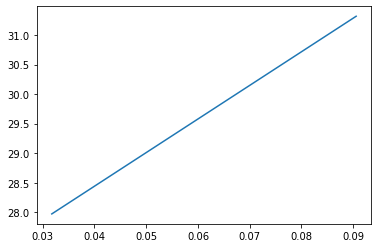

In [6]:
plt.plot(*list(zip(*my_coords["lena"])))

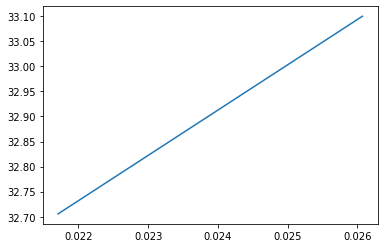

In [7]:
plt.plot(*list(zip(*jpg_coords["lena"])))

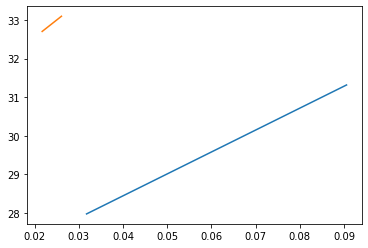

In [8]:
plt.plot(*list(zip(*my_coords["lena"])))
plt.plot(*list(zip(*jpg_coords["lena"])))